In [1]:
import pylab as pl
import pandas as pd
import numpy as np
import os
import scipy.stats
from sklearn.cluster import KMeans
pl.style.use('fivethirtyeight')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Reading, cleaning, and merging

In [2]:
# read in geography crosswalk data
geoxwalk = pd.read_csv(os.path.expandvars('$PUI2015/ny_xwalk.csv.gz'), compression = 'gzip')

# read in 2002 OD data
od = pd.read_csv(os.path.expandvars('$PUI2015/ny_od_main_JT00_2002.csv.gz'), compression = 'gzip')

/Users/erwan/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (27,28,29,35) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [3]:
# limit crosswalk data to NYC
geoxwalk_nyc = geoxwalk[(geoxwalk.ctyname == 'Bronx County, NY') |
                           (geoxwalk.ctyname == 'Kings County, NY') |
                           (geoxwalk.ctyname == 'Queens County, NY') |
                           (geoxwalk.ctyname == 'New York County, NY') |
                           (geoxwalk.ctyname == 'Richmond County, NY')]

# limit crosswalk data to block code and census tract
geoxwalk_nyc = geoxwalk_nyc[['tabblk2010', 'trct']]

# limit OD data to home block code, work block code, and jobs
od = od[['h_geocode', 'w_geocode', 'S000']]

In [4]:
# merge OD data with crosswalk data as 'inner' join so that only OD data within NYC are stored
# two joins are required (I think) to join on both h_geocode and w_geocode
merge_result = pd.merge(od, geoxwalk_nyc, left_on='h_geocode', right_on='tabblk2010', how='inner')
merge_result = pd.merge(merge_result, geoxwalk_nyc, left_on='w_geocode', right_on='tabblk2010', how='inner')

In [5]:
# limit OD data to jobs and census tracts, rename accordingly
merge_result = merge_result[['trct_x', 'trct_y', 'S000']]
merge_result.columns = ['h_trct', 'w_trct', 0]

In [6]:
# group OD data by census tract
grouped = merge_result.groupby((merge_result['h_trct'], merge_result['w_trct']))

In [7]:
# create lists for each column
od_dict = {}
od_dict['h_trct'] = []
od_dict['w_trct'] = []
od_dict[0] = []

In [8]:
# iterate through grouped OD data and append information to relevant lists
for k, group in grouped:
    od_dict['h_trct'].append(k[0]) 
    od_dict['w_trct'].append(k[1])
    od_dict[0].append(group[0].sum())

In [9]:
# create new dataframe from completed lists
od = pd.DataFrame.from_dict(od_dict, orient = 'columns')

In [10]:
# create list of remaining OD data to read
list1 = ['$PUI2015/ny_od_main_JT00_2003.csv.gz', '$PUI2015/ny_od_main_JT00_2004.csv.gz', '$PUI2015/ny_od_main_JT00_2005.csv.gz', '$PUI2015/ny_od_main_JT00_2006.csv.gz', '$PUI2015/ny_od_main_JT00_2007.csv.gz', '$PUI2015/ny_od_main_JT00_2008.csv.gz', '$PUI2015/ny_od_main_JT00_2009.csv.gz', '$PUI2015/ny_od_main_JT00_2010.csv.gz', '$PUI2015/ny_od_main_JT00_2011.csv.gz', '$PUI2015/ny_od_main_JT00_2012.csv.gz', '$PUI2015/ny_od_main_JT00_2013.csv.gz']

for i in range(0,len(list1)):
    # read OD data from index i of list1
    od_temp = pd.read_csv(os.path.expandvars(list1[i]), compression = 'gzip')
    
    # merge OD data with crosswalk data as 'inner' join so that only OD data within NYC is stored
    merge_result = pd.merge(od_temp, geoxwalk_nyc, left_on='h_geocode', right_on='tabblk2010', how='inner')
    merge_result = pd.merge(merge_result, geoxwalk_nyc, left_on='w_geocode', right_on='tabblk2010', how='inner')
    
    # limit OD data to jobs and census tracts, rename accordingly
    merge_result = merge_result[['trct_x', 'trct_y', 'S000']]
    merge_result.columns = ['h_trct', 'w_trct', i+1]
    
    # group OD data by census tract
    grouped = merge_result.groupby((merge_result['h_trct'], merge_result['w_trct']))
    
    # create lists for each column
    od_dict = {}
    od_dict['h_trct'] = []
    od_dict['w_trct'] = []
    od_dict[i+1] = []
    
    # iterate through grouped OD data and append information to relevant lists
    for k, group in grouped:
        od_dict['h_trct'].append(k[0]) 
        od_dict['w_trct'].append(k[1])
        od_dict[i+1].append(group[i+1].sum())
        
    # create new dataframe from completed dictionary
    od_temp = pd.DataFrame.from_dict(od_dict, orient = 'columns')
    
    # join od with od_temp
    od = pd.merge(od, od_temp, how = 'outer', on=['h_trct', 'w_trct'])

## Clustering

In [11]:
od.save('od.pkl')

/Users/erwan/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:1000: FutureWarning: save is deprecated, use to_pickle
  warnings.warn("save is deprecated, use to_pickle", FutureWarning)


In [12]:
# replace all NaN values with 0
# this is a huge assumption on my part, and we might want to discuss whether or not this is prudent
od = od.fillna(0)

# set a threshold of 25 jobs over the course of 12 years, so as to take a substantive sample
# 25 was chosen very arbitrarily and might be a bad value, again we should discuss this
od_cut = od[(od[0] + od[1] + od[2] + od[3] + od[4] + od[5] + od[6] + od[7] + od[8] + od[9] + od[10] + od[11]) > 25]

In [13]:
# print shape of dataframe
print od_cut.shape

(229039, 14)


In [14]:
# limit OD data to jobs
od_cut_jobs = od_cut[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]

# normalize according to J'=(J-<J>)/std(J)
od_norm = od_cut_jobs.sub(od_cut_jobs.mean(axis=1), axis=0)
od_norm = od_norm.div(od_cut_jobs.std(axis=1), axis=0)

In [15]:
# put dataframe values into an array for clustering
od_array = od_norm.values

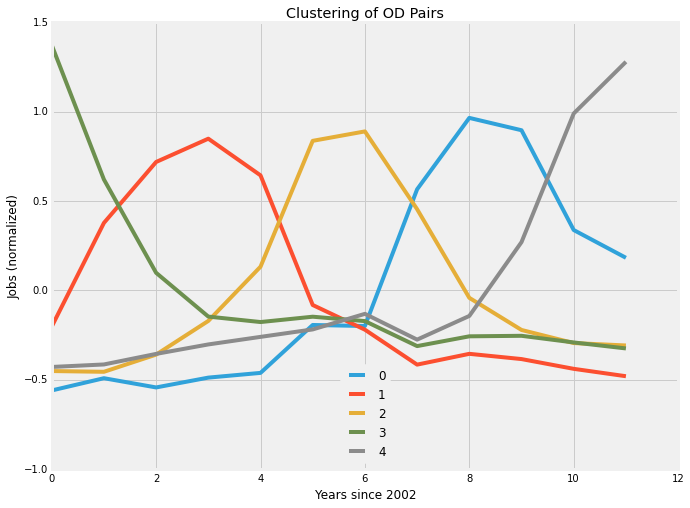

In [16]:
# perform clustering and plotting
fig = pl.figure(figsize=(10, 8))
pl.title('Clustering of OD Pairs')
pl.xlabel('Years since 2002')
pl.ylabel('Jobs (normalized)')

kmeans = KMeans(n_clusters=5)
kmeans.fit(od_array)
for i in range(5):
    pl.plot(kmeans.cluster_centers_[i], label = i)
    
pl.legend(loc='lower center')

In [44]:
print od_array[90]

[-0.26850955  0.19179254 -1.18911372 -1.18911372 -0.03835851 -1.41926476
 -0.72881163  0.42194358  1.80284983  0.65209462  1.11239671  0.65209462]


In [ ]:
index = kmeans.labels_ == 0
pl.figure()
for ii in range (len(od_array)):
    if index[ii] == True:
        pl.plot(od_array[ii], color = 'k', lw = 0.001)
        pl.plot(kmeans.cluster_centers_[ii], color = 'dodgerblue')

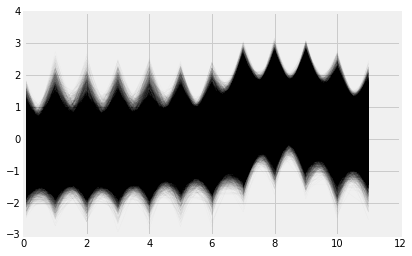

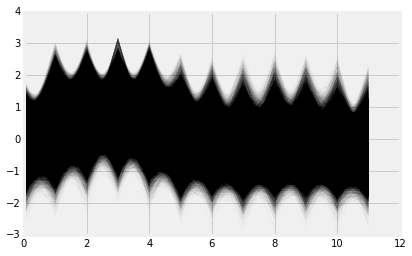

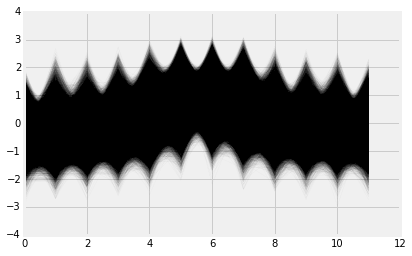

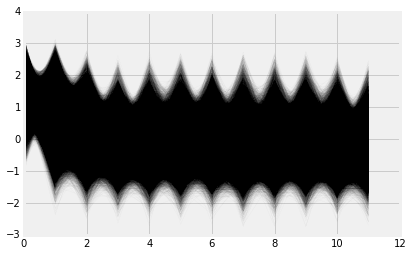

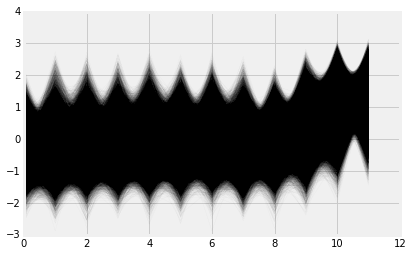

In [49]:
for j in range(kmeans.n_clusters):
    index = kmeans.labels_ == j
    pl.figure()
    for ii in range (len(od_array)):
        if index[ii] == True:   
            pl.plot(od_array[ii], color = 'k', lw = 0.01)
    pl.plot(kmeans.cluster_centers_[ii], color = 'dodgerblue')